In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from load_clean_data import load_clean_data

c:\Users\wongy\OneDrive\Desktop\School\Y2S2\INF2006_CloudComputing\Assignment\INF2006-Assignment-2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("Task4").getOrCreate()


In [3]:
# Load the data
df = load_clean_data("./data", spark)


In [4]:
# Group by channel and calculate the mean and median of the trusting points
df_grouped = df.groupBy("_channel").agg(
    F.mean("_trust").alias("mean_trusting_points"),
    F.median("_trust").alias("median_trusting_points")
)


In [5]:
# Show the results
df_grouped.show(df_grouped.count(), False)


+----------------+--------------------+----------------------+
|_channel        |mean_trusting_points|median_trusting_points|
+----------------+--------------------+----------------------+
|prizeplank      |1.0                 |1.0                   |
|instagc         |0.9086886074429764  |0.9259                |
|bitcoinget      |0.9577211864406794  |0.9615                |
|tremorgames     |0.8287998293970339  |0.8108                |
|coinworker      |0.8390619450317137  |0.8571                |
|keeprewarding   |0.866699999999999   |0.8667                |
|inboxpounds     |0.9375              |0.9375                |
|neodev          |0.8399505561040375  |0.8378                |
|zoombucks       |0.9283105102818009  |0.9189                |
|cotter          |0.9188999999999999  |0.9189                |
|surveymad       |0.8474142857142861  |0.8182                |
|tasks4dollars   |0.8106617647058824  |0.8125                |
|globalactioncash|0.7999999999999998  |0.8             

## Code below this point is testing for Task 6

In [6]:
from pyspark.sql.types import ArrayType, StringType

# replicating task 2
def top_n_reasons(reasons, counts, n=5):
    return [reason for reason, count in sorted(zip(reasons, counts), key=lambda x: x[1], reverse=True)[:n]]

df_non_unknown = df.filter((F.col("airline").isNotNull()) & (F.col("airline") != "NULL") & (F.col("negativereason1").isNotNull()) & (F.col("negativereason1") != "Unknown"))
top_n_udf = F.udf(top_n_reasons, ArrayType(StringType()))

top_neg_reasons = df_non_unknown.groupBy('airline', 'negativereason1') \
    .agg(F.count('negativereason1').alias('reason_count'))

# Group by airline again to collect all reasons and counts into lists
airline_reasons = top_neg_reasons.groupBy('airline') \
    .agg(F.collect_list('negativereason1').alias('all_reasons'), 
         F.collect_list('reason_count').alias('all_counts'))

# top 5 reasons for each airline
top_5_neg_reasons = airline_reasons.withColumn('top_5_reasons', top_n_udf('all_reasons', 'all_counts'))

top_5_neg_reasons.select('airline', 'top_5_reasons').show(truncate=False)

+--------------+--------------------------------------------------+
|airline       |top_5_reasons                                     |
+--------------+--------------------------------------------------+
|Delta         |[CSProblem, late, canttell, cancel, lostluggae]   |
|Virgin America|[CSProblem, canttell, booking, badflight, cancel] |
|United        |[CSProblem, late, canttell, cancel, lostluggae]   |
|US Airways    |[CSProblem, late, canttell, cancel, lostluggae]   |
|Southwest     |[CSProblem, cancel, badflight, canttell, late]    |
|American      |[CSProblem, late, cancel, canttell, airplanestaff]|
+--------------+--------------------------------------------------+



In [7]:
#rerun task 4 but with airline instead of channel
df_airline_mean_median = df_non_unknown.groupBy("airline").agg(
    F.mean("_trust").alias("mean_trust"),
    F.median("_trust").alias("median_trust"),
    F.count("_trust").alias("count"),
    F.min("_trust").alias("min_trust"),
    F.max("_trust").alias("max_trust")
)

df_airline_mean_median.show(df_airline_mean_median.count(), False)

+--------------+------------------+------------+-----+---------+---------+
|airline       |mean_trust        |median_trust|count|min_trust|max_trust|
+--------------+------------------+------------+-----+---------+---------+
|Delta         |0.8467654679199157|0.8462      |48940|0.7      |1.0      |
|Virgin America|0.8447668308391737|0.8378      |5279 |0.7083   |1.0      |
|United        |0.8483956278026709|0.8571      |98120|0.7      |1.0      |
|US Airways    |0.84782647507983  |0.8438      |72030|0.7      |1.0      |
|Southwest     |0.8469651732377699|0.8462      |50220|0.7      |1.0      |
|American      |0.8577683932695432|0.8649      |90930|0.7      |1.0      |
+--------------+------------------+------------+-----+---------+---------+



In [8]:
#see if there is a correlation between the trust and the negative reasons
df_airline_mean_median.join(top_5_neg_reasons, on='airline', how='inner').show(df_airline_mean_median.count(), False)

+--------------+------------------+------------+-----+---------+---------+-------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------------------+
|airline       |mean_trust        |median_trust|count|min_trust|max_trust|all_reasons                                                                                                  |all_counts                                                     |top_5_reasons                                     |
+--------------+------------------+------------+-----+---------+---------+-------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------------------+
|Delta         |0.8467654679199157|0.8462      |48940|0.7      |1.0      |[late, damagedluggage, can

In [9]:
# get number of retweets and favorites for each airline
df_retweets_favorites = df_non_unknown.groupBy("airline").agg(
    F.sum("retweet_count").alias("total_retweets")
)

df_retweets_favorites.show(df_retweets_favorites.count(), False)

+--------------+--------------+
|airline       |total_retweets|
+--------------+--------------+
|Delta         |3010          |
|Virgin America|50            |
|United        |13930         |
|US Airways    |8970          |
|Southwest     |4440          |
|American      |2690          |
+--------------+--------------+



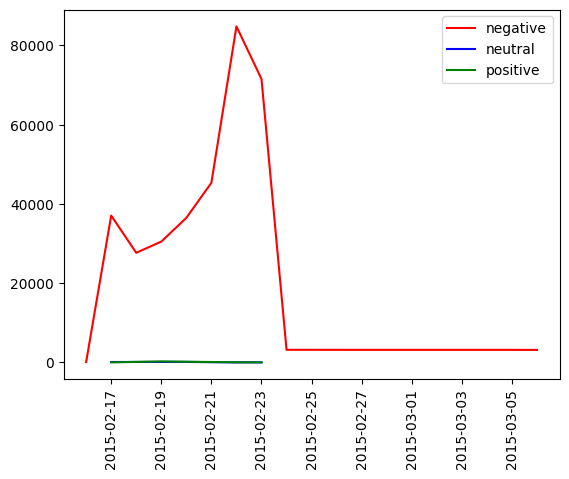

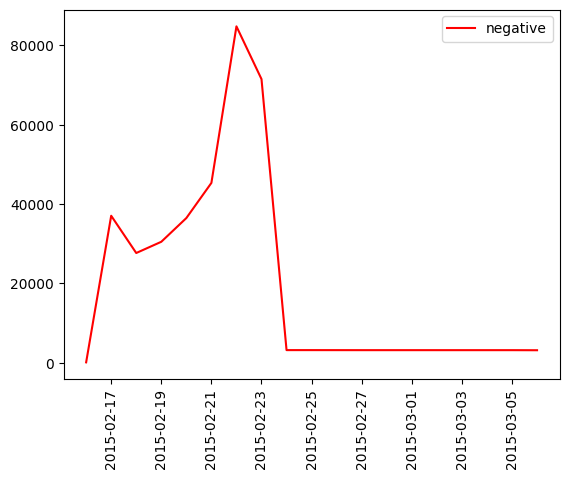

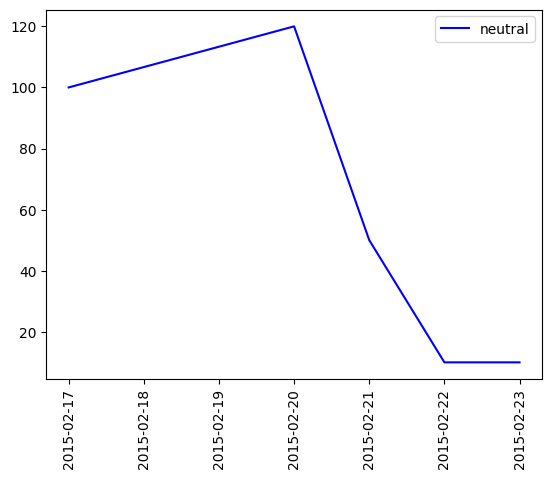

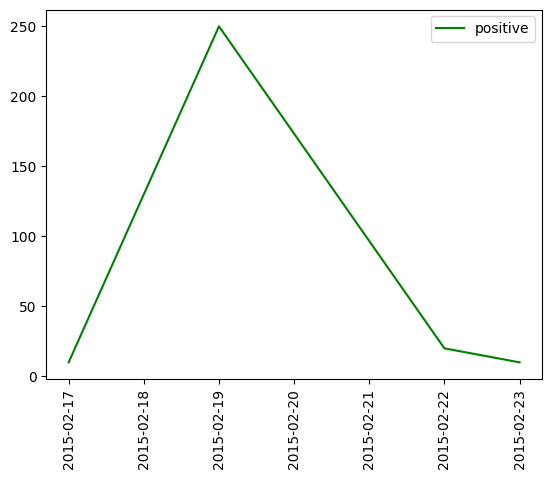

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# plot airline_sentiment against date of tweet
df_date = df_non_unknown
# remove time from date
df_date = df_date.withColumn("tweet_created", F.to_date("tweet_created", "dd-MM-yyyy"))


df_date = df_date.groupBy("tweet_created", "airline_sentiment").count().toPandas()
# df_date['tweet_created'] = pd.to_datetime(df_date['tweet_created']).dt.date
# remove time from date
# df_date['tweet_created'] = df_date['tweet_created'].dt.date
df_date = df_date.sort_values(by="tweet_created")

# plot all sentiments on the same graph
fig, ax = plt.subplots()
# plot line
ax.plot(
    df_date[df_date["airline_sentiment"] == "negative"]["tweet_created"],
    df_date[df_date["airline_sentiment"] == "negative"]["count"],
    label="negative",
    color="red",
)
ax.plot(
    df_date[df_date["airline_sentiment"] == "neutral"]["tweet_created"],
    df_date[df_date["airline_sentiment"] == "neutral"]["count"],
    label="neutral",
    color="blue",
)
ax.plot(
    df_date[df_date["airline_sentiment"] == "positive"]["tweet_created"],
    df_date[df_date["airline_sentiment"] == "positive"]["count"],
    label="positive",
    color="green",
)
# df_date[df_date['airline_sentiment'] == 'negative'].plot(x='tweet_created', y='count', ax=ax, label='negative', colors='red')
# df_date[df_date['airline_sentiment'] == 'neutral'].plot(x='tweet_created', y='count', ax=ax, label='neutral', colors='blue')
# df_date[df_date['airline_sentiment'] == 'positive'].plot(x='tweet_created', y='count', ax=ax, label='positive', colors='green')
# change the x axis to be more readable
plt.legend()
plt.xticks(rotation=90)
plt.show()

# plot each sentiment on a separate graph
fig, ax = plt.subplots()
ax.plot(
    df_date[df_date["airline_sentiment"] == "negative"]["tweet_created"],
    df_date[df_date["airline_sentiment"] == "negative"]["count"],
    label="negative",
    color="red",
)
plt.legend()
# df_date[df_date['airline_sentiment'] == 'negative'].plot(x='tweet_created', y='count', ax=ax, label='negative', colors='red')
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots()
ax.plot(
    df_date[df_date["airline_sentiment"] == "neutral"]["tweet_created"],
    df_date[df_date["airline_sentiment"] == "neutral"]["count"],
    label="neutral",
    color="blue",
)
plt.legend()
# df_date[df_date['airline_sentiment'] == 'neutral'].plot(x='tweet_created', y='count', ax=ax, label='neutral', colors='blue')
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots()
ax.plot(
    df_date[df_date["airline_sentiment"] == "positive"]["tweet_created"],
    df_date[df_date["airline_sentiment"] == "positive"]["count"],
    label="positive",
    color="green",
)
plt.legend()
# df_date[df_date['airline_sentiment'] == 'positive'].plot(x='tweet_created', y='count', ax=ax, label='positive', colors='green')
plt.xticks(rotation=90)
plt.show()

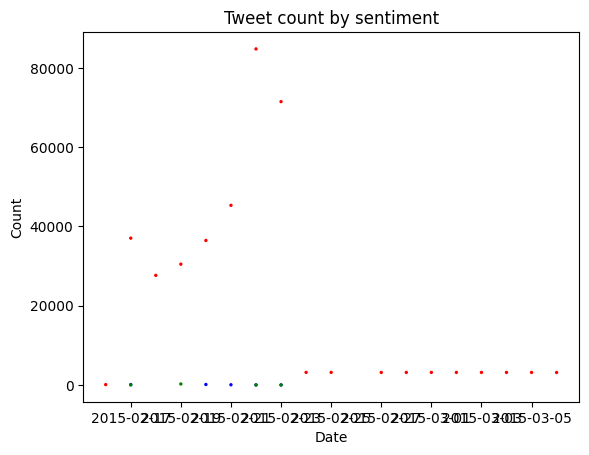

In [11]:
#scatter plot visualization testing
fig, ax = plt.subplots()
colors = {'negative':'red', 'neutral':'blue', 'positive':'green'}
ax.scatter(df_date['tweet_created'], df_date['count'], c=df_date['airline_sentiment'].apply(lambda x: colors[x]), s=2)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Tweet count by sentiment')
plt.show()